# Homework 2 (HW2)

---
By the end of this homework we expect you to be able to:
1. Preprocess data and make it amenable to statistical analysis and machine learning models;
2. Train and test out-of-the-box machine learning models in Python;
3. Carry out statistical hypothesis testing;
4. Carry out simple multivariate regression analyses;
5. Use techniques to control for covariates;

---

## Important Dates

- Homework release: Fri 12 Nov 2021
- **Homework due**: Fri 26 Nov 2021, 23:59
- Grade release: Fri 03 Dec 2021

---

##  Some rules

1. You are allowed to use any built-in Python library that comes with Anaconda. If you want to use an external library, 
you may do so, but must justify your choice.
2. Make sure you use the `data` folder provided in the repository in read-only mode. (Or alternatively, be sure you 
don’t change any of the files.)
3. Be sure to provide a textual description of your thought process, the assumptions you made, the solution you 
implemented, and explanations for your answers. A notebook that only has code cells will not suffice.
4. For questions containing the **/Discuss:/** prefix, answer not with code, but with a textual explanation
 (**in markdown**).
5. Back up any hypotheses and claims with data, since this is an important aspect of the course.
6. Please write all your comments in English, and use meaningful variable names in your code. Your repo should have a 
single notebook (plus the required data files) in the *master/main* branch. If there are multiple notebooks present, 
we will **not grade** anything.
7. We will **not run your notebook for you**! Rather, we will grade it as is, which means that only the results 
contained in your evaluated code cells will be considered, and we will not see the results in unevaluated code cells. 
Thus, be sure to hand in a **fully-run and evaluated notebook**. In order to check whether everything looks as intended, you can check the rendered notebook on the GitHub website once you have pushed your solution there.
8. In continuation to the previous point, interactive plots, such as those generated using `plotly`, should be **strictly avoided**!
9. Make sure to print results or dataframes that confirm you have properly addressed the task.

---

## Context

Congratulations! You have just been hired as a data scientist at *Piccardi Music,* a promising new music label created by a mysterious Italian disc jockey "*Signor Piccardi*". The company hired you to carry out a variety of data-related tasks, which will be explained in further detail below.

---

## The data

For this homework you will use a dataset of 18,403 music reviews scraped from Pitchfork¹, including relevant metadata such as review author, review date, record release year, review score, and genre, along with the respective album's audio features pulled from Spotify's API. The data consists of the following columns:

| Column   | Description  |
|----------|:-------------|
| `artist`           | The name of the artist who created the album being reviewed. |
| `album`            | The name of the album being reviewed. |
| `recordlabel`      | The name of the record label(s) who published the album. |
| `releaseyear`      | The year that the album was released. |
| `score`            | The score given to the album by the reviewer on a scale of 0.0 to 10.0. |
| `reviewauthor`     | The name of the author who reviewed the album. |
| `genre`            | The genre assigned to the album by Pitchfork. |
| `reviewdate`       | The date that the review was published.  |
| `key` | The estimated overall musical key of the track. Integers map to pitches using standard Pitch Class notation (e.g., 0 = C, 2 = D, and so on) |
| `acousticness` | A confidence measure from 0.0 to 1.0 of whether an album is acoustic. 1.0 represents high confidencethat the album is acoustic. |
| `danceability` | How suitable an album is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 1.0 is most danceable.
| `energy` | A perceptual measure of intensity and activity, from 0.0 to 1.0, where 1.0 represents high energy. Metal is often high energy. |
| `instrumentalness` | Predicts whether an album contains no vocals, from 0.0 to 1.0. The closer to 1.0, the more likely the album contains no vocals. |
| `liveness` | Detects the presence of an audience, from 0.0 to 1.0. Scores greater than 0.8 indicate a strong likelihood the album is live. |
| `loudness` | The overall loudness of the album in decibels (dB). |
| `speechiness` | Measures the presence of spoken words in an album on a scale from 0.0 to 1.0. Scores higher than 0.66 indicate an album made entirely of spoken words, while scores below 0.33 indicate music and other non-speech-like elements. |
| `valence` | A measure from 0.0 to 1.0 describing the musical positiveness conveyed by an album, where values closer to 1.0 indicate more positive sounds. |
| `tempo` | The overall estimated tempo of an album in beats per minute (BPM). |

¹Pinter, Anthony T., et al. "P4KxSpotify: A Dataset of Pitchfork Music Reviews and Spotify Musical Features." Proceedings of the International AAAI Conference on Web and Social Media. Vol. 14. 2020.

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker

import seaborn as sns
import numpy as np
import scipy
import itertools

# datetime operations
from datetime import datetime

# multiprocessing
from joblib import Parallel, delayed

# ttest and euclidean distance
from scipy.stats import ttest_ind
from scipy.spatial.distance import seuclidean

# linear fit using statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

# good ole sklearn
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances, r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

# displaying markdown strings
from IPython.display import display, Markdown, Latex

sns.set_style('whitegrid')

## Part 1: Will this album be a hit?

The first project you embark on in your new job is to build a regressor to predict whether an album will be well received or not. According to *Signor Piccardi* (your boss), this algorithm may eventually be helpful in forecasting the success of albums produced by *Piccardi Music*.

**Task 1 (Initial analyses — 10 pts)**

As a good data scientist, the first thing you do is to have a good look at the data that was handed to you.

1. Load the data using `pandas`. Identify and remove duplicate reviews, i.e., two reviews with albums by the same band with the same name (keep the first occurrence). Print the number of rows in your dataframe.

2. Plot the distribution of album release years and the average score of albums per year.

3. For numerical columns, calculate the mean, median, minimum value and maximum value. Additionally, plot the distribution for all the numerical columns in a single image (possibly with multiple subplots). Your image should be at most 14 inches wide by 14 inches long.

3. For categorical columns, list how many different values there are in each column. If there are less than 10 distinct values for a category, print them all. For the `genre` column, assign the value `'Other'` for albums where the value is either `'none'` or `NaN`.

5. **Discuss:** This dataset was built with *found data*—i.e., the Pitchfork reviews were not made with the goal of training a machine learning model. Grounded on the previous analyses and in Pitchfork's [Wikipedia page](https://en.wikipedia.org/wiki/Pitchfork_(website)), point **three** (exactly!) ways in which this data may not be representative of music albums in general due to the way the data was collected. 

---

In [28]:
# 1.1

pitchfork = pd.read_csv('./data/pitchfork.csv.gz')
pitchfork = pitchfork.drop_duplicates(subset=["album", "artist"], keep="first")
print("Num. rows: " + str(len(pitchfork)))
pitchfork.head()

Num. rows: 16738


,artist,album,reviewauthor,score,releaseyear,reviewdate,recordlabel,genre,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Studio 1,Studio 1,Andy Battaglia,8.5,2009.0,February 18 2009,Studio,Electronic,0.511917,0.499667,5.250000,-5.626583,0.031983,0.724917,0.024493,0.165367,0.555083,101.395167
1,John Fahey,The Great Santa Barbara Oil Slick,Mark Richardson,8.2,2005.0,February 13 2005,Water,Folk/Country,0.369765,0.325412,4.470588,-19.153824,0.148624,0.647053,0.559133,0.527782,0.179465,107.622647
2,Reigning Sound,Too Much Guitar,Stephen M. Deusner,8.3,2004.0,August 19 2004,In the Red,Electronic,0.253943,0.912857,4.428571,-1.089500,0.055500,0.000253,0.751214,0.199071,0.552786,133.895500
3,The Red Thread,After the Last,Chris Dahlen,7.3,2003.0,July 17 2003,Badman,Rock,0.425400,0.433474,5.700000,-12.871000,0.028260,0.310325,0.224137,0.125150,0.451400,104.354200
4,Mac Miller,Swimming,Evan Rytlewski,7.5,2018.0,August 3 2018,Warner Bros.,Rap,0.624846,0.438154,4.153846,-9.456077,0.170246,0.652462,0.012819,0.121131,0.281138,122.121308


In [29]:
numeric_cols = ['score', 'releaseyear', 'danceability', 'energy', 'key',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo']
for i in numeric_cols:
    pitchfork = pitchfork.loc[pitchfork[i] != -1].copy(deep=True)


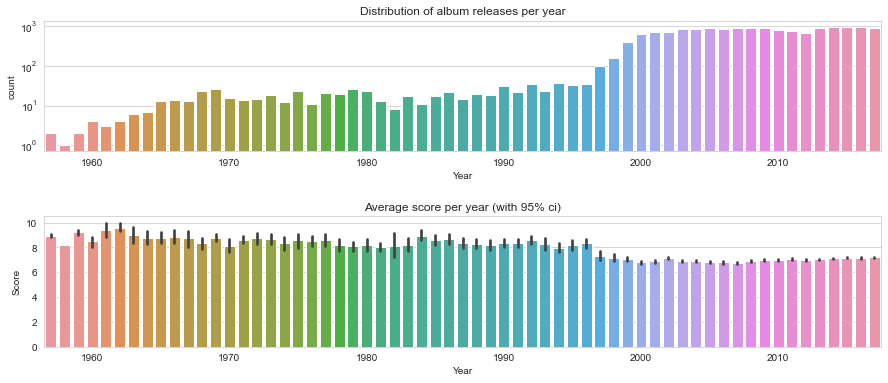

In [30]:
# 1.2

pitchfork['reviewdate'] = pd.to_datetime(pitchfork['reviewdate'], format='%B %d %Y')
pitchfork['releaseyear'] = pd.to_datetime(pitchfork['releaseyear'], format='%Y')
pitchfork['releaseyear_notutc'] = pitchfork.releaseyear.dt.year

fig, axs = plt.subplots(2, 
                        figsize=(15,6), 
                        gridspec_kw={"hspace": 0.5}, # increases vertical spacing a bit
                        sharex=False)

# Plot distribution of album release years
ax = axs[0]
ax = sns.countplot(data=pitchfork, x='releaseyear_notutc',  ax=ax)
ax.set(title='Distribution of album releases per year', xlabel='Year')
ax.set_yscale("log") # log scale!

# fixes the x-axis!
ax.xaxis.set_major_formatter(lambda x, pos: str(int(x) + 1957))
ax.set_xticks([3, 13, 23, 33, 43, 53])
ax.tick_params(axis='x', rotation=0)


# ... and average score of albums per year
ax = axs[1]
ax = sns.barplot(data=pitchfork, x='releaseyear_notutc', y='score', ci=95, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: str(int(x) + 1957))

# fixes the x-axis!
ax.set_xticks([3, 13, 23, 33, 43, 53])
ax.set(title='Average score per year (with 95% ci)', xlabel='Year', ylabel='Score')
ax.tick_params(axis='x', rotation=0)

plt.show();

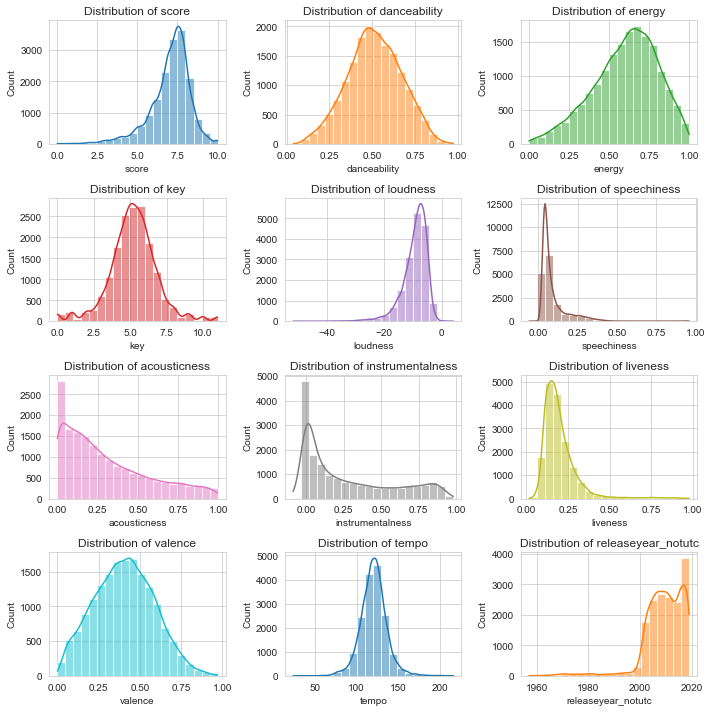

,count,mean,std,min,25%,50%,75%,max
score,16731.0,7.048563,1.247042,0.000000,6.500000,7.300000,7.800000,10.000
danceability,16731.0,0.512967,0.155850,0.038667,0.409000,0.511364,0.622700,0.974
energy,16731.0,0.601946,0.200580,0.000126,0.474182,0.624800,0.749732,0.999
key,16731.0,5.219102,1.609161,0.000000,4.333333,5.230769,6.100000,11.000
loudness,16731.0,-9.286734,4.235869,-51.728750,-11.218202,-8.445300,-6.396427,4.078
speechiness,16731.0,0.091199,0.087339,-0.058236,0.040645,0.056673,0.100279,0.958
acousticness,16731.0,0.302459,0.261092,0.000001,0.091182,0.229000,0.460720,0.996
instrumentalness,16731.0,0.275281,0.297830,-0.085783,0.009683,0.149620,0.497540,0.982
liveness,16731.0,0.196902,0.102061,0.015300,0.134545,0.174294,0.228350,0.978
valence,16731.0,0.405856,0.180050,0.000010,0.274400,0.406300,0.531811,0.971


In [31]:
# 1.3

numeric_cols = pitchfork.select_dtypes(include=['int64','float64']).columns

# nice plot!
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(10,10))
for i,(col,ax) in enumerate(zip(numeric_cols, axs.flatten())):
    sns.histplot(data=pitchfork[col],ax=ax, bins=20, kde=True, color=f'C{i}')
    ax.set(title=f'Distribution of {col}')
    
plt.tight_layout()
plt.show()

# nice table!
pitchfork.describe().T

In [32]:
# 1.4 

# Applying pd.where to replace eveything which is either null according to pandas (np.NaN, None) or the 'none' string

pitchfork['genre'] = pitchfork['genre'].where(
    ~((pd.isnull(pitchfork['genre']) | (pitchfork['genre'] == 'none'))), 
    other='Other'
)

# Printing all the categorical columns

cat_cols = ['artist', 'album', 'reviewauthor', 'recordlabel', 'genre']

display_all = lambda cat : f'({", ".join(pitchfork[cat].unique())})' if pitchfork[cat].nunique() <= 10 else ''

for cat in cat_cols:
    display(Markdown(f'Category **{cat}** has **{pitchfork[cat].nunique()}** unique values {display_all(cat)}'))

Category **artist** has **7890** unique values 

Category **album** has **16177** unique values 

Category **reviewauthor** has **554** unique values 

Category **recordlabel** has **3030** unique values 

Category **genre** has **10** unique values (Electronic, Folk/Country, Rock, Rap, Global, Experimental, Metal, Pop/R&B, Jazz, Other)

**1.5** 

First, as we could see in 1.3, the distribution of releases per year starts to ramp up a lot after the year 2000.
This suggests that the website is more likely to publish reviews for more recent releases, and, thus, 
the proportion of albums per years in the dataset is not representative of the real life proportion of releases.

Second, this dataset does not represent accurately the proportion of genres of releases, as said in the Wikipedia article, the "website's journalism favored independent music, favoring lo-fi and often obscure indie rock."

Third, Pitchfork reviews are made by a small set of American individuals, these many not accurately represent the opinion of other music reviewers.

#### **Task 2 (Pre-processing and pipeline code — 12 pts)**

Next, you decide to prepare the code that will help you in training your machine learning models. Also, you implement a simple baseline. For this task, **unless otherwise stated** you must implement functions yourself, instead of relying on `scikit-learn` (you can use `numpy` or `pandas`, though!).

1. For each possible value in the `genre` column, create a new column called `{genre}_onehot` (e.g., for `genre=jazz`, create `jazz_onehot`). Collectively, these new columns should "one hot-encode" the genre column—for instance, if for a given album the `genre` is filled with the value `jazz`, the `jazz_onehot` column should equal 1 and all other `{genre}_onehot` columns should equal 0. 

2. Create a function `numpy_helper(df, cols)` to obtain a `numpy.array` out of your `dataframe`. The function should receive a dataframe `df` with N rows and a list of M columns `cols`, and should return a `np.array` of dimension (NxM).

3. For each album, build an array of features `X` containing all genre-related one-hot features, and an array of outcomes `y` containing scores. Using the function [`sklearn.model_selection.train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) with `random_state=123`, split the data into a train set containing 70% of all data, and a test set containing the remaining 30%.

4. Create your own baseline regressor. Using the training data (in the training stage), your regressor should estimate the average score for all albums. Then, for the test data (in the prediction stage), your classifier should always output the average score (computed on the training data).

5. Calculate the [coefficient of determination ($R^2$)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) of your baseline on the test data. **You are allowed to use the `sklearn` implementation here.**

6. **Discuss:** Your train-test split randomly selected 70% of all data for the training set. Why is this a problem for the broader task of predicting whether a future album will be successful or not?

---

In [33]:
# 2.1

pitchfork = pitchfork.join(pd.get_dummies(pitchfork['genre']).rename(columns=lambda x : f'{x}_onehot'))

In [34]:
# 2.2 

numpy_helper = lambda df, cols : df[cols].values

In [35]:
# 2.3

genre_cols = list(filter(lambda x : x.endswith('_onehot'), pitchfork.columns))

X = numpy_helper(pitchfork, genre_cols)
y = np.ravel(numpy_helper(pitchfork, ['score']))

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.3, random_state=123)

In [36]:
# 2.4
class BaselineRegressor():

    def __init__(self):
        self.baselines_ = None

    def fit(self, X, y):

        self.baselines_ = y.mean()
        
        # Return the classifier
        return self

    def predict(self, X):


        return np.array([self.baselines_] * len(X))
    

clf = BaselineRegressor()

clf.fit(X_train, y_train)

preds = clf.predict(X_test)

preds

array([7.03911707, 7.03911707, 7.03911707, ..., 7.03911707, 7.03911707,
       7.03911707])

In [37]:
# 2.5 

r2_score(y_test, preds)

-0.0006600097628044477

**2.6** Forecasting is a harder problem than regression in that sense because a lot can vary over time. Musical taste for example, change with time, so it is harder to precit what will be popular in the future than what is popular now.

**Task 3 (Regression — 18 pts)**

Finally, you get down to business and train your regression models.

1. Build a Linear Regression model (use `sklearn`) that predicts the outcome `score` using the features "releaseyear",  "key", "acousticness", "danceability", "energy", "instrumentalness", "liveness", "loudness", "speechiness", "valence", "tempo" and the one-hot encoded genre-related columns.  Using a 70/30 train-test split similar to what you did in task two (hereinafter referred to as "the random split", use the same random seed, `random_state=123`), report the $R^2$ for the testing set.

2. Create an alternate train-test split (hereinafter referred to as "the longitudinal split") where you train with data from albums released before 2000 and test with data from 2003 and after. Report the $R^2$ for the testing set using the same model you developed for the previous question. **Discuss:** give the correct interpretation of $R^2$ value for the longitudinal split.

3. For a given entry $X$ your model outputs a predicted score $Y'$. The difference between the real score $Y$ and the predicted score $Y'$ is called the "residual". Considering the model trained in 3.2, plot the distribution of your residuals for the test set. Additionally, estimate what is the probability that your score prediction (from 3.2) is off by more than 2-points? Provide bootstrapped confidence intervals for your answer.

4. Experiment with training a different regressor, a Gradient Boosting Regressor. This regressor is related to the Boosted decision trees that you have seen in class. This model performs extremely well for a variety of tasks and is often used in machine learning competitions for tabular data (e.g., on Kaggle). Train the regressor using the longitudinal split and the same features as in 3.2, use the default hyperparameters. Report the $R^2$ for the testing set. 

5. **Discuss:** Hypothesize a reason for the difference in performance between the Linear regression and the Gradient Boosting Regressor.

---

In [38]:
# 3.1

pitchfork['releaseint'] = pitchfork['releaseyear'].astype(int).copy()

features = ["releaseint", "key", "acousticness", "danceability", "energy", "instrumentalness", "liveness",
            "loudness", "speechiness", "valence", "tempo"] + genre_cols

X = numpy_helper(pitchfork, features)
y = np.ravel(numpy_helper(pitchfork, ['score']))

# r for random split
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
     X, y, test_size=0.3, random_state=123)

reg = LinearRegression()

reg.fit(X_train_r, y_train_r)

preds = reg.predict(X_test_r)

print(r2_score(y_test_r, preds))

0.020858591941966265


In [39]:
# 3.2

# Selecting data before and after the cut
dt_2000 = datetime(2000,1,1)
dt_2003 = datetime(2003,1,1)
long_df_train = pitchfork[pitchfork['releaseyear'] <= dt_2000]
long_df_test  = pitchfork[pitchfork['releaseyear'] >= dt_2003]

X_train_l = numpy_helper(long_df_train, features)
y_train_l = np.ravel(numpy_helper(long_df_train, ['score']))
X_test_l  = numpy_helper(long_df_test, features)
y_test_l  = np.ravel(numpy_helper(long_df_test, ['score']))

X_train_l.shape, y_train_l.shape, X_test_l.shape, y_test_l.shape

reg = LinearRegression()

reg.fit(X_train_l, y_train_l)

preds = reg.predict(X_test_l)

print(r2_score(y_test_l, preds))

-0.0836514240268047


**3.2 (cont)** In cases where negative values arise, the mean of the data provides a better fit to the outcomes than do the fitted function values, according to this particular criterion.

(0.0834, 0.0946)

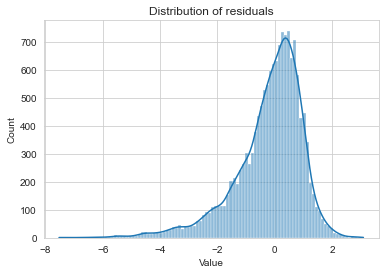

In [40]:
# 3.3

# Computing the residuals
resid = y_test_l - preds


# Plotting the residuals

hist, bins = np.histogram(resid, bins=100)

sns.histplot(data=resid, kde=True, bins=bins)

plt.gca().set(title='Distribution of residuals', xlabel='Value')

# bootstrapping

def bootstrap_samples(random_samples,seed):
    
    np.random.seed(seed)
    
    rand_arr = np.random.choice(random_samples, len(random_samples))
    
    return (rand_arr >= 2).mean()

# create a single distribution
rv_hist = scipy.stats.rv_histogram((hist, bins))

# sampling from the distribution
random_samples = [abs(rv_hist.rvs()) for _ in range(10_000)]

# bootstrap_sampling probas
probas = np.array([bootstrap_samples(random_samples, i) for i in range(1_000)])

# quantiles
np.quantile(probas, 0.025), np.quantile(probas, 0.975)

In [41]:
# 3.4

# Fitting our GradientBoostingRegressor and checking the R2 score on the test set like in 3.1
reg = GradientBoostingRegressor()

reg.fit(X_train_l, y_train_l)

preds = reg.predict(X_test_l)

print(r2_score(y_test_l, preds))

-0.3052394146389983


**3.5** The gradient boosting regressor overfits to the training data, making it even worse than the linear regression.

**Task 4 (Are we solving the correct problem? — 12 pts)**

All your efforts so far have assumed that decisions are taken at the "album" level, which is often not the case for bands with multiple albums. In those cases, it could be interesting to predict what is the success of a given band album given the features of the album **and of previous albums**.

1. Create a new dataframe that contains one row per band with more than 1 album. This dataframe should have the same columns as the data provided to you, considering the latest album of the respective band (note that this is determined by the release year of the album, not the date when it was reviewed). Additionally, for each feature considered in Task 3.1 (including the one-hot encoded features), create an additional column post-fixed with `_previous` (e.g., `danceability_previous`). These columns should contain the average values for all of the band's previous albums. Also, create a column `score_previous` with the average score of previous albums. Print the number of rows in the dataframe as well as the name of the columns.

2. Train a Gradient Boosting Regressor considering all features created in Task 4.1 (note that `score` is the outcome and everything else is a feature, including `score_previous`). Use the 70/30 random train-test split, the default hyperparameters, and report the $R^2$ for the testing set. 

3. Can hyperparameter tuning improve your model? Write modular code (i.e., a function) to divide your training data into $N$ folds and perform cross-validation. Experiment tuning two hyperparameters of the Gradient Boosting Regressor: `n_estimators` and `learning_rate`. For each possible combination of the two hyperparameters (see below for the range of values that you should try for each hyperparameter), train your model in a cross-validation setup with $N=20$ folds. Report the mean  $R^2$ along with the 90% CI for each scenario. 
    - n_estimators $ \in  \{ 100, 200, 300, 400\}$
    - learning_rate $ \in  \{ 0.1, 0.05, 0.01\}$.
 
 With the best hyperparameters obtained, train your model with the entire training set and report the $R^2$ on the testing set.
 
4. **Discuss:** How do these results compare with the previous setup (the scenario considered in **Task 3.4**)? Point out two reasons why it is hard to compare the results obtained in 4.3 and 3.4 at face value? How would you fairly compare the two different setups?

---

In [42]:
# 4.1

features_no_onehot = ['key',
 'acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'valence',
 'tempo'] + genre_cols

# Creating two dataframes:
# - one where we select all except the last album and compute the mean (which will become the _previous columns), 
# - and the second where we select only the last album, and then join them back together.

# keep only artists
filtered_artists = pitchfork.groupby('artist').size().loc[lambda x : x > 1].index
only_artists = pitchfork[pitchfork.artist.isin(filtered_artists)]

# per artist, drop last and take mean
previous_df = (only_artists
               .sort_values(by='releaseyear')
               .groupby('artist')
               .apply(lambda x : x.iloc[:-1][features_no_onehot + ['score']]
                      .mean(axis=0))
               .rename(columns=lambda x : f'{x}_previous'))

# per artist, only take last
artist_df = (only_artists
             .sort_values(by='releaseyear')
             .groupby('artist')
             .apply(lambda x : x.iloc[-1]))

# join the two dfs back together
new_df = artist_df.join(previous_df)

In [43]:
# 4.2

previous_cols = new_df.columns[new_df.columns.str.endswith('_previous')]
new_features = features + list(previous_cols)


X_new = numpy_helper(new_df, new_features)
y_new = np.ravel(numpy_helper(new_df, ['score']))

X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(
     X_new, y_new, test_size=0.3, random_state=123)

reg = GradientBoostingRegressor()

reg.fit(X_train_n, y_train_n)

preds = reg.predict(X_test_n)

r2_score(y_test_n, preds)

0.1942227845015312

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done   7 out of  12 | elapsed:  3.9min remaining:  2.8min
[Parallel(n_jobs=4)]: Done   9 out of  12 | elapsed:  5.8min remaining:  1.9min
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:  8.2min finished


0.21293782628923041

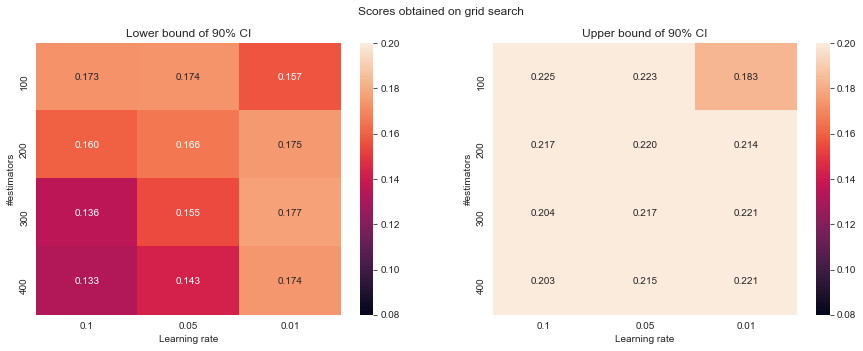

In [44]:
# 4.3

params = {
    'n_estimators':[100, 200, 300 ,400],
    'learning_rate':[0.1,0.05,0.01]
}

def cross_val_single_param(X,y,param,kfold,reg_class=GradientBoostingRegressor):
    r2s = []
        
    for train_ind, test_ind in kfold.split(X):
        
        # train indices
        X_train = X[train_ind]
        y_train = y[train_ind]
        
        # test indices
        X_test = X[test_ind]
        y_test = y[test_ind]
        
        # create classifier, fit, predict
        reg = reg_class(**param)
        
        reg.fit(X_train, y_train)
        preds = reg.predict(X_test)
        
        # add r2 score to array
        r2s += [r2_score(y_test, preds)]
        
    return r2s

def cross_val(X,y,params,N=20, n_jobs=4):
    
    # generate list of params
    params_list = [{name:y for name,y in zip(params.keys(),x)} for x in list(itertools.product(*params.values()))]
        
    # create kfold splitter
    kfold = KFold(N)
    
    # apply cross_val score function for each param set we have
    scores = Parallel(n_jobs=n_jobs, verbose=10)(delayed(cross_val_single_param)(X,y,param,kfold) 
                                                 for param in params_list)
    
    return scores

scores = cross_val(X_train_n, y_train_n, params)

def bootstrap_ci(x):
    mean_vals = [np.random.choice(x,len(x)).mean() for _ in range(1000)]
    return np.quantile(mean_vals, 0.05), np.quantile(mean_vals, 0.95)

scores_reshaped = np.array([bootstrap_ci(x) for x in scores]).reshape([len(x) for x in params.values()] + [-1])

fig, axs = plt.subplots(ncols=2, figsize=(15,5))

manual_params = dict(
    yticklabels=params['n_estimators'],
    xticklabels=params['learning_rate'],
    vmin=0.08,
    vmax=0.2,
    annot=True,
    fmt='.3f'
)

sns.heatmap(data=scores_reshaped[:,:,0], ax=axs[0], **manual_params)
sns.heatmap(data=scores_reshaped[:,:,1], ax=axs[1], **manual_params)

axs[0].set(title='Lower bound of 90% CI')
axs[1].set(title='Upper bound of 90% CI')

for i in range(2):
    axs[i].set(ylabel='#estimators', xlabel='Learning rate')
    
plt.suptitle('Scores obtained on grid search');

reg = GradientBoostingRegressor(n_estimators=400, learning_rate=0.01)

reg.fit(X_train_n, y_train_n)

preds = reg.predict(X_test_n)

r2_score(y_test_n, preds)

**4.4 —** The coefficient of determination is higher for this scenario, meaning that using this scenario we are better to better predict the dependent variable — It seems that considering the history of each band in making the predictions results in better predictions. However, comparing the results from 4.3 with those obtained in 3.4 at face value is not appropriate since:

- Here we have limited our sample to bands containing multiple albums.
- Here we have fine-tuned our parameters.

A better comparison would take both these things into account.


## Part 2: Second Album Syndrome

Your second project at *Piccardi Music* is to shed light on one of the business's oldest enigmas: the "second album syndrome." In a nutshell, the "second album syndrome" is a theory that states that the second album of a band always sucks. ([Related read](https://tvtropes.org/pmwiki/pmwiki.php/Main/SophomoreSlump))

Assume—for the purpose of this task—that the Pitchfork data contains all albums for all artists it covers (even though this might not be true in reality).

**Task 5 (Preliminary analyses — 10 pts)**

You begin by carrying out some preliminary data processing and analyses.

1. Create a new dataframe (from the original data with duplicates dropped, the same as you obtained after finishing Task 1.1) containing only albums from artists with two or more albums and where the release year is not empty.
2. Create a new column `album_number` which indicates how many albums the artist has produced before this one (before the second album, the artist has already produced one album).
3. Calculate the mean and the standard error fo the mean of the scores of the first and second albums in the dataset. Additionally, plot the two distributions. 
4. Use an appropriate method to determine if the difference in means of 1st and 2nd albums is statistically significant?
5. **Discuss:** Do these analyses suggest that the "second album syndrome" exists?

---

In [45]:
# 5.1

pitchfork = pd.read_csv('data/pitchfork.csv.gz')
pitchfork = pitchfork.drop_duplicates(subset=["album", "artist"], keep="first")
pitchfork['reviewdate'] = pd.to_datetime(pitchfork['reviewdate'], format='%B %d %Y')
pitchfork['releaseyear'] = pd.to_datetime(pitchfork['releaseyear'], format='%Y')
pitchfork['releaseyear_notutc'] = pitchfork.releaseyear.dt.year

# artists with more than 1 album
filtered_artists = pitchfork.groupby('artist').size().loc[lambda x : x > 1].index

# copying so we don't accidentally modify original df
two_ormore = pitchfork[pitchfork.artist.isin(filtered_artists)].copy()

In [46]:
# 5.2

# adding album number
two_ormore.loc[:,'album_number'] = (two_ormore
                              .sort_values(by=['releaseyear', 'reviewdate'])
                              .groupby('artist')['album']
                              .transform(lambda x : range(len(x))))

# example artist:
two_ormore.sort_values(by=['releaseyear', 'reviewdate'])\
          .query('artist == "Young Thug"')[['releaseyear','reviewdate','album_number']]

,releaseyear,reviewdate,album_number
8396,2015-01-01,2015-04-24,0
11547,2015-01-01,2015-09-24,1
8735,2016-01-01,2016-02-09,2
11546,2016-01-01,2016-03-30,3
482,2016-01-01,2016-09-01,4
15816,2017-01-01,2017-06-20,5
13411,2017-01-01,2017-09-26,6
80,2018-01-01,2018-08-22,7
16524,2019-01-01,2019-08-21,8


,mean,sem
album_number,,
0,7.303002,0.020686
1,7.038468,0.021327


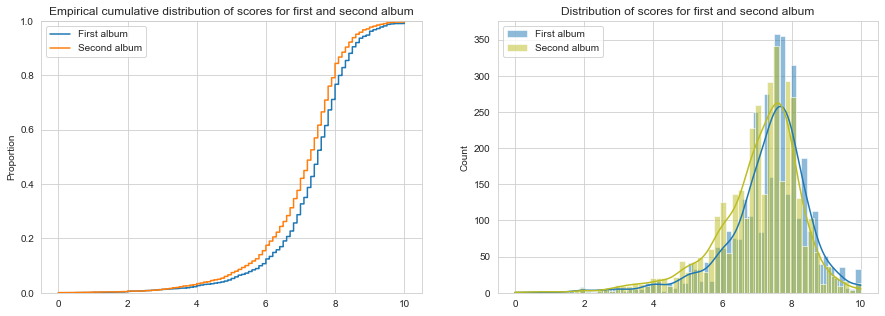

In [47]:
# 5.3

display(two_ormore.groupby('album_number')['score'].agg(['mean', 'sem']).loc[[0,1]])

zeros, ones = two_ormore.loc[two_ormore['album_number'].isin([0,1])].groupby('album_number')['score'].apply(list)
fig, axs = plt.subplots(ncols=2, figsize=(15,5))

sns.ecdfplot(zeros, label='First album', ax=axs[0])
sns.ecdfplot(ones, label='Second album', ax=axs[0])

axs[0].legend()
axs[0].set(title='Empirical cumulative distribution of scores for first and second album')

sns.histplot(zeros, kde=True, alpha=0.5, label='First album', ax=axs[1])
sns.histplot(ones,kde=True, alpha=0.5, label='Second album', color='C8', ax=axs[1])

axs[1].legend()
axs[1].set(title='Distribution of scores for first and second album');

In [48]:
# 5.4

zeros, ones = two_ormore.loc[two_ormore['album_number'].isin([0,1])].groupby('album_number')['score'].apply(list)

ttest_ind(zeros, ones)

Ttest_indResult(statistic=8.903441019634526, pvalue=6.775768621489928e-19)

**5.5 —** The analyses are in accordance with the hypothesis, since we indeed find a significant decrease in the average score of the second album.

**Task 6 (Regression analysis — 21 pts)**

Next, you proceed to examine some hypotheses about the "second album syndrome" using a regression framework. Namely:

- The **time spent hypothesis:**  the first album usually has a couple of years of development under its belt and plenty of trial and error from live concerts to help the band determine what does or doesn't work. The second album, on the other hand, is often made in a rush.

- The **style change hypothesis:** bands often try to change their style after their first album. This change is not always welcomed by the listeners.

1. Create a new dataframe containing one row per 1st-2nd album pair. The dataframe should contain rows:
    - `score_diff`: the difference in scores between the second and the first album (second - first).
    - `time_diff`: the number of days elapsed between the first and the second album.
    - `did_style_change`: a dummy variable that indicates whether the style of the music has changed. To obtain it, first, calculate the [standardized euclidean distance](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.seuclidean.html) of music-related numerical features¹ between the second and the first album. Second, assign 1 to the 20% most distant 1st-2nd album pairs and 0 to all others.
2. Fit a linear regression using `statsmodels` with this dataframe. Your regression should consider only an intercept, i.e., `"score_diff ~ 1"`.
3. **Discuss:** Interpret the $R^2$ in your regression here. Does this analysis confirm what you observed in Task 5? Why?
4. Include the `time_diff` and `did_style_change` as covariates in your model. Fit the regression again and report the summary of your model. 
5. **Discuss:** Interpret the coefficients `time_diff` and `did_style_change`. Carefully explain whether they provide evidence towards each of the aforementioned hypotheses? Do they rule out other reasons that may cause the "second album syndrome effect"?
6. Create a new column called `time_diff_standardized`. It should be a standardized version of the `time_diff` column. Repeat the regression done in 6.4 using the `time_diff_standardized` column instead of the `time_diff` column.
7. **Discuss:** Explain how the interpretation of the coefficients associated with this new column `time_diff_standardized` differ from its non-standardized version 
`time_diff`?

--- 

**¹** Music related numerical features are:  "key", "acousticness", "danceability", "energy", "instrumentalness", "liveness", "loudness", "speechiness", "valence", and "tempo".


In [50]:
# 6.1

music_features = ["key", "acousticness", "danceability", "energy", "instrumentalness", "liveness", 
                  "loudness", "speechiness", "valence", "tempo"]

first_two = two_ormore[two_ormore.album_number.isin((0,1))]

variances = first_two[music_features].var()

def agg_func(x):
    
    assert len(x) == 2
    
    # get the two parts of the df
    first, second = x.iloc[0], x.iloc[1]
    
    
    
    # compute the 3 features
    score_d = second['score'] - first['score']
    time_d  = abs(first['releaseyear'] - second['releaseyear'])
    dist    = seuclidean(first[music_features], second[music_features], variances)
    
    # return the 3 features as columns
    return pd.Series([score_d, time_d, dist], index =['score_diff', 'time_diff', 'dist'])

# apply our aggregation function
pair_df = first_two.sort_values(by='releaseyear').groupby('artist').apply(agg_func)

# get the cut value for highest 20%
quantile_8th = pair_df['dist'].quantile(q=0.8)

pair_df['time_diff'] = pair_df['time_diff'].dt.days 

# assign style change to 1 if in the 20% highest
pair_df.loc[:,'did_style_change'] = 0
pair_df.loc[pair_df['dist'] >= quantile_8th,'did_style_change'] = 1

In [51]:
pair_df = pair_df[pair_df.time_diff != 0]

In [52]:
# 6.2

mod = smf.ols(formula='score_diff ~ 1', data=pair_df)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             score_diff   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 01 Dec 2021   Prob (F-statistic):                nan
Time:                        19:50:16   Log-Likelihood:                -5888.2
No. Observations:                3389   AIC:                         1.178e+04
Df Residuals:                    3388   BIC:                         1.178e+04
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2747      0.024    -11.628      0.0

**6.3** The $R^2$ formula is:
    
$$
R^2 = 1 - \frac{\sum_i (y_i - f_i)}{{\sum_i (y_i - \bar{y}_i)}}
$$

Where $y_i$ is the outcome of the i-th datapoint, $f_i$ is the prediction of the model, and $\bar{y}_i$ is the average outcome. Here, as the regression only has an intercept, the prediction equals the mean, and thus the $R^2$ equals 0.

Note that what we are doing here is very similar to a t-test (what was done in Task 5), there, we were looking if the difference in averages was significantly different, here, we are looking whether the average difference in paired outcomes is significantly bigger than 0.



In [53]:
# 6.4
pair_df["time_diff_standardized"] = (pair_df["time_diff"] - pair_df["time_diff"].mean()) / pair_df["time_diff"].std()
mod = smf.ols(formula='score_diff ~ 1 + time_diff + did_style_change', data=pair_df)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             score_diff   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     29.80
Date:                Wed, 01 Dec 2021   Prob (F-statistic):           1.48e-13
Time:                        19:50:16   Log-Likelihood:                -5858.7
No. Observations:                3389   AIC:                         1.172e+04
Df Residuals:                    3386   BIC:                         1.174e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.1485      0.030  

**6.5 —** The results suggest that neither of the hypotheses trying to explain the "Second Album Syndrome" are true:

- The coefficient associated with the time difference is negative: this implies that the longer time goes by, the worse the score of the next album will be. This is the opposite of what the time spent hypothesis says.
- The coefficient associated with the style change is not significant.

Even when controlling for these two covariates, we still find a significant difference between the first and second album in each band, captured by the intercept.

In [54]:
# 6.6
pair_df["time_diff_standardized"] = (pair_df["time_diff"] - pair_df["time_diff"].mean()) / pair_df["time_diff"].std()
mod = smf.ols(formula='score_diff ~ 1 + time_diff_standardized + did_style_change', data=pair_df)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             score_diff   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     29.80
Date:                Wed, 01 Dec 2021   Prob (F-statistic):           1.48e-13
Time:                        19:50:16   Log-Likelihood:                -5858.7
No. Observations:                3389   AIC:                         1.172e+04
Df Residuals:                    3386   BIC:                         1.174e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0

**6.7 —** In the non-standardized case, one unit change in the coefficient associated with `time_diff` 
represents by how the score between the second and first album changes, in average, per each day passed between the two. In the standardized case, one unit change represents the change associated with a one standard deviation in the regressor `time_diff`.

**Task 7 (Sanity checks — 6 pts)**

You decide to perform a few last sanity checks for your analysis.

1.  **Discuss:** If the Second Album Syndrome existed, i.e., something was special about the second album (as in if it was bad for a very particular reason that afflicted album number 2 more than all others), what would you expect to happen to the mean score of the third album?
2. Using the dataset you created in Task 5, calculate the mean and the standard error of the mean for the 1st, 2nd, 3rd, and 4th albums. Test whether the difference between the average score of the second and the third album is statistically significant.
3. **Discuss:** Does this suggest that the Second Album Syndrome exists?


**7.1 —** If something was particularly bad about the second album, we'd expect the score of the third album to increase relative to the second album.

In [55]:
# 7.2
ones, twos = two_ormore.loc[two_ormore['album_number'].isin([1,2])].groupby('album_number')['score'].apply(list)
display(two_ormore.groupby('album_number')['score'].agg(['mean', 'sem']).loc[[0, 1, 2, 3, ]])

ttest_ind(twos, ones)

,mean,sem
album_number,,
0,7.303002,0.020686
1,7.038468,0.021327
2,7.044410,0.027617
3,7.040662,0.036123


Ttest_indResult(statistic=0.16816255372281083, pvalue=0.8664615688260937)

**7.3 —** No, because the average score of the albums after the first seems to become stable.

**Task 8 (Eureka — 14 pts)**

Your boss, *Signor Piccardi*, proposes that you carry out a simulation to make things clearer. Assuming that:


- Each band $i$ has a "talent" $\mu_i$ , which is uniformally distributed between 2 and 8, i.e., $\mu_i \sim U_{[2,8]}$.
- When a band $i$ produces an album $j$, it has quality $s_j$. This score is normally distributed with mean $\mu_i$ and standard deviation $1$, i.e., $s_j \sim N(\mu_i, 1)$
- Talents are independent and identically distributed random variables.
 
Carry out the following simulation:

- Create 1000 hypothetical bands with intrinsic talents $\mu_i \sim U_{[2,8]}$ for $i \in [1,1000]$.
- Have each hypothetical band create a hypothetical album.
- Discard all bands whose albums received a score smaller than 6.
- For each of the remaining bands, create two additional albums.

Analyzing the scores obtained in this simulation, provide a coherent explanation for the scores obtained in Task 7.2. 

--- 

**Hint:** You can use numpy to sample random variables (e.g. [numpy.random.normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html))

In [56]:
import numpy.random as rdm

talents = rdm.uniform(2, 8, 1000)

albums1 = np.array([rdm.normal(talent, 1) for talent in talents])

# filtered bands
talents_filtered = talents[albums1 >= 6] 
albums_filtered = albums1[albums1 >= 6]

albums2 = np.array([rdm.normal(talent, 1) for talent in talents_filtered])
albums3 = np.array([rdm.normal(talent, 1) for talent in talents_filtered])

print("1st albums:", albums_filtered.mean())
print("2nd albums:", albums2.mean())
print("3rd albums:", albums3.mean())

1st albums: 7.226361076373319
2nd albums: 6.787043083747212
3rd albums: 6.843123222213465


Both in the simulation and in the real data analyzed, it is likely we are observing an instance of **regression to the mean.** 

- In the pitchfork data: bands that produce a very good first album are more likely to be reviewed by a magazine like Pitchfork —If no one knows the band, and the album is not good, why would they review it? However, it is likely that the album was very good partially due to chance. In that context, the second and third albuns of the band are less likely to be as good.

- In the simulation: we reproduce this same dynamic. We discard bands that performed poorly, but we will definitely keep some bands that performed well despite having low intrinsic talent (due to sheer chance). When we create additional albums for these bands, we see that the score decreases.